## Dependencies

In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)

seed = 0
seed_everything(seed)
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import *

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Load data

In [2]:
new_data = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_data = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# Preprocecss data
old_data = old_data[['image', 'level']]
old_data.columns = new_data.columns
old_data["id_code"] = old_data["id_code"].apply(lambda x: x + ".jpeg")
new_data["id_code"] = new_data["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")

# Sample Half of the new data to be used as validation
new_train, X_val = train_test_split(new_data, test_size=0.5, random_state=seed)

# Sample rows of diagnosis = 0
diag_0 = old_data[old_data['diagnosis'] == 0].sample(frac=0.25, random_state=seed)
diag_oth = old_data[old_data['diagnosis'] != 0]
old_train = diag_0.append(diag_oth)
X_train = new_train.append(old_train)

print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])
display(X_train.head())

Number of train samples:  17599
Number of validation samples:  1831
Number of test samples:  1928


,id_code,diagnosis
2213,9b70f84400af.png,0
2792,c0e509786f7f.png,4
2522,aeab0a63bcaf.png,0
3364,e97ecf4355cb.png,0
3484,f26b02ead915.png,0


# Model parameters

In [3]:
# Model parameters
FACTOR = 4
BATCH_SIZE = 8 * FACTOR
EPOCHS = 25
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4 * FACTOR
WARMUP_LEARNING_RATE = 1e-3 * FACTOR
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
TTA_STEPS = 5
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
LR_WARMUP_EPOCHS_1st = 2
LR_WARMUP_EPOCHS_2nd = 5
STEP_SIZE = len(X_train) // BATCH_SIZE
TOTAL_STEPS_1st = WARMUP_EPOCHS * STEP_SIZE
TOTAL_STEPS_2nd = EPOCHS * STEP_SIZE
WARMUP_STEPS_1st = LR_WARMUP_EPOCHS_1st * STEP_SIZE
WARMUP_STEPS_2nd = LR_WARMUP_EPOCHS_2nd * STEP_SIZE

# Pre-procecess images

In [4]:
old_data_base_path = '../input/diabetic-retinopathy-resized/resized_train/resized_train/'
new_data_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def circle_crop(img):
    img = crop_image(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = width//2
    y = height//2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)

    return img
        
def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
    
def preprocess_old_train(df, base_path=old_data_base_path, save_path=train_dest_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        image_id = df.iloc[i]['id_code']
        preprocess_image(image_id, base_path, save_path)
        
def preprocess_new_train(df, base_path=new_data_base_path, save_path=train_dest_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        image_id = df.iloc[i]['id_code']
        preprocess_image(image_id, base_path, save_path)
        
def preprocess_validation(df, base_path=new_data_base_path, save_path=validation_dest_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        image_id = df.iloc[i]['id_code']
        preprocess_image(image_id, base_path, save_path)
        
def preprocess_test(df, base_path=test_base_path, save_path=test_dest_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        image_id = df.iloc[i]['id_code']
        preprocess_image(image_id, base_path, save_path)

n_cpu = mp.cpu_count()
old_train_n_cnt = old_train.shape[0] // n_cpu
new_train_n_cnt = new_train.shape[0] // n_cpu
val_n_cnt = X_val.shape[0] // n_cpu
test_n_cnt = X_val.shape[0] // n_cpu

# Pre-procecss old data train set
pool = mp.Pool(n_cpu)
dfs = [old_train.iloc[old_train_n_cnt*i:old_train_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = old_train.iloc[old_train_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_old_train, [x_df for x_df in dfs])
pool.close()

# Pre-procecss new data train set
pool = mp.Pool(n_cpu)
dfs = [new_train.iloc[new_train_n_cnt*i:new_train_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = new_train.iloc[new_train_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_new_train, [x_df for x_df in dfs])
pool.close()

# Pre-procecss validation set
pool = mp.Pool(n_cpu)
dfs = [X_val.iloc[val_n_cnt*i:val_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_val.iloc[val_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_validation, [x_df for x_df in dfs])
pool.close()

# Pre-procecss test set
pool = mp.Pool(n_cpu)
dfs = [test.iloc[test_n_cnt*i:test_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = test.iloc[test_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_test, [x_df for x_df in dfs])
pool.close()

# Data generator

In [5]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory=train_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

test_generator=datagen.flow_from_dataframe(  
                       dataframe=test,
                       directory=test_dest_path,
                       x_col="id_code",
                       batch_size=1,
                       class_mode=None,
                       shuffle=False,
                       target_size=(HEIGHT, WIDTH),
                       seed=seed)

Found 17599 validated image filenames.
Found 1831 validated image filenames.
Found 1928 validated image filenames.


In [6]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """
    Cosine decay schedule with warm up period.
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    :param global_step {int}: global step.
    :param learning_rate_base {float}: base learning rate.
    :param total_steps {int}: total number of training steps.
    :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
    :param warmup_steps {int}: number of warmup steps. (default: {0}).
    :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
    :param global_step {int}: global step.
    :Returns : a float representing learning rate.
    :Raises ValueError: if warmup_learning_rate is larger than learning_rate_base, or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler"""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """
        Constructor for cosine decay with warmup learning rate scheduler.
        :param learning_rate_base {float}: base learning rate.
        :param total_steps {int}: total number of training steps.
        :param global_step_init {int}: initial global step, e.g. from previous checkpoint.
        :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
        :param warmup_steps {int}: number of warmup steps. (default: {0}).
        :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
        :param verbose {int}: quiet, 1: update messages. (default: {0}).
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

# Model

In [7]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

for layer in model.layers:
    layer.trainable = False

for i in range(-2, 0):
    model.layers[i].trainable = True

cosine_lr_1st = WarmUpCosineDecayScheduler(learning_rate_base=WARMUP_LEARNING_RATE,
                                           total_steps=TOTAL_STEPS_1st,
                                           warmup_learning_rate=0.0,
                                           warmup_steps=WARMUP_STEPS_1st,
                                           hold_base_rate_steps=(2 * STEP_SIZE))

metric_list = ["accuracy"]
callback_list = [cosine_lr_1st]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     callbacks=callback_list,
                                     verbose=2).history

Epoch 1/5
 - 241s - loss: 1.7738 - acc: 0.3086 - val_loss: 1.5212 - val_acc: 0.2621
Epoch 2/5
 - 223s - loss: 1.2477 - acc: 0.2924 - val_loss: 1.5706 - val_acc: 0.2357
Epoch 3/5
 - 225s - loss: 1.2285 - acc: 0.3018 - val_loss: 1.5115 - val_acc: 0.2251
Epoch 4/5
 - 223s - loss: 1.2155 - acc: 0.2942 - val_loss: 1.6716 - val_acc: 0.1895
Epoch 5/5
 - 225s - loss: 1.1622 - acc: 0.3033 - val_loss: 1.6176 - val_acc: 0.2140


# Fine-tune the complete model

In [10]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
cosine_lr_2nd = WarmUpCosineDecayScheduler(learning_rate_base=LEARNING_RATE,
                                           total_steps=TOTAL_STEPS_2nd,
                                           warmup_learning_rate=0.0,
                                           warmup_steps=WARMUP_STEPS_2nd,
                                           hold_base_rate_steps=(3 * STEP_SIZE))

callback_list = [es, cosine_lr_2nd]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [11]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=2).history

Epoch 1/25
 - 500s - loss: 1.0246 - acc: 0.3290 - val_loss: 0.5849 - val_acc: 0.5442
Epoch 2/25
 - 464s - loss: 0.8655 - acc: 0.3706 - val_loss: 0.4800 - val_acc: 0.6103
Epoch 3/25
 - 463s - loss: 0.7557 - acc: 0.4035 - val_loss: 0.3951 - val_acc: 0.6809
Epoch 4/25
 - 462s - loss: 0.6792 - acc: 0.4466 - val_loss: 0.4341 - val_acc: 0.6465
Epoch 5/25
 - 463s - loss: 0.6488 - acc: 0.4614 - val_loss: 0.3720 - val_acc: 0.7565
Epoch 6/25
 - 463s - loss: 0.6252 - acc: 0.4790 - val_loss: 0.3888 - val_acc: 0.6459
Epoch 7/25
 - 464s - loss: 0.5977 - acc: 0.4944 - val_loss: 0.4552 - val_acc: 0.6687
Epoch 8/25
 - 462s - loss: 0.5687 - acc: 0.5138 - val_loss: 0.3186 - val_acc: 0.8016
Epoch 9/25
 - 462s - loss: 0.5578 - acc: 0.5296 - val_loss: 0.3324 - val_acc: 0.7738
Epoch 10/25
 - 461s - loss: 0.5348 - acc: 0.5382 - val_loss: 0.3471 - val_acc: 0.7387
Epoch 11/25
 - 461s - loss: 0.5119 - acc: 0.5540 - val_loss: 0.2916 - val_acc: 0.7715
Epoch 12/25
 - 461s - loss: 0.5051 - acc: 0.5634 - val_loss: 0.

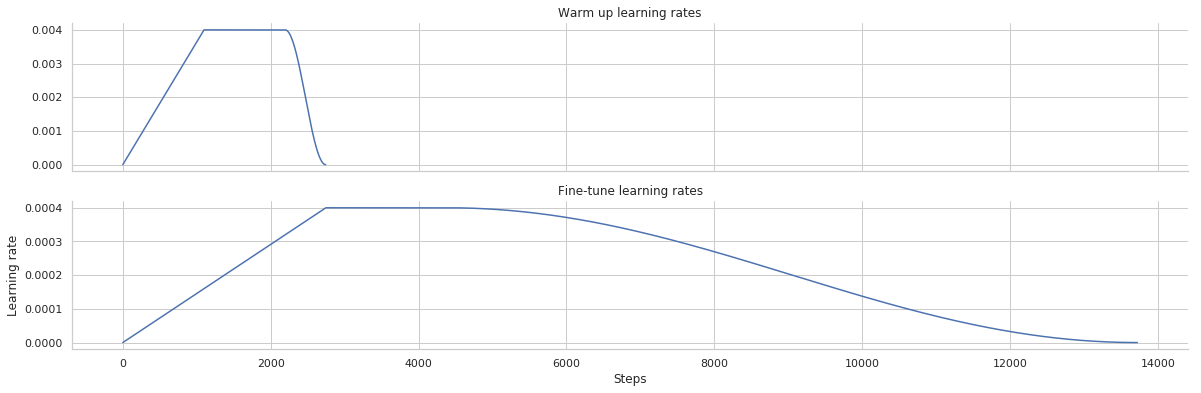

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 6))

ax1.plot(cosine_lr_1st.learning_rates)
ax1.set_title('Warm up learning rates')

ax2.plot(cosine_lr_2nd.learning_rates)
ax2.set_title('Fine-tune learning rates')

plt.xlabel('Steps')
plt.ylabel('Learning rate')
sns.despine()
plt.show()

# Model loss graph 

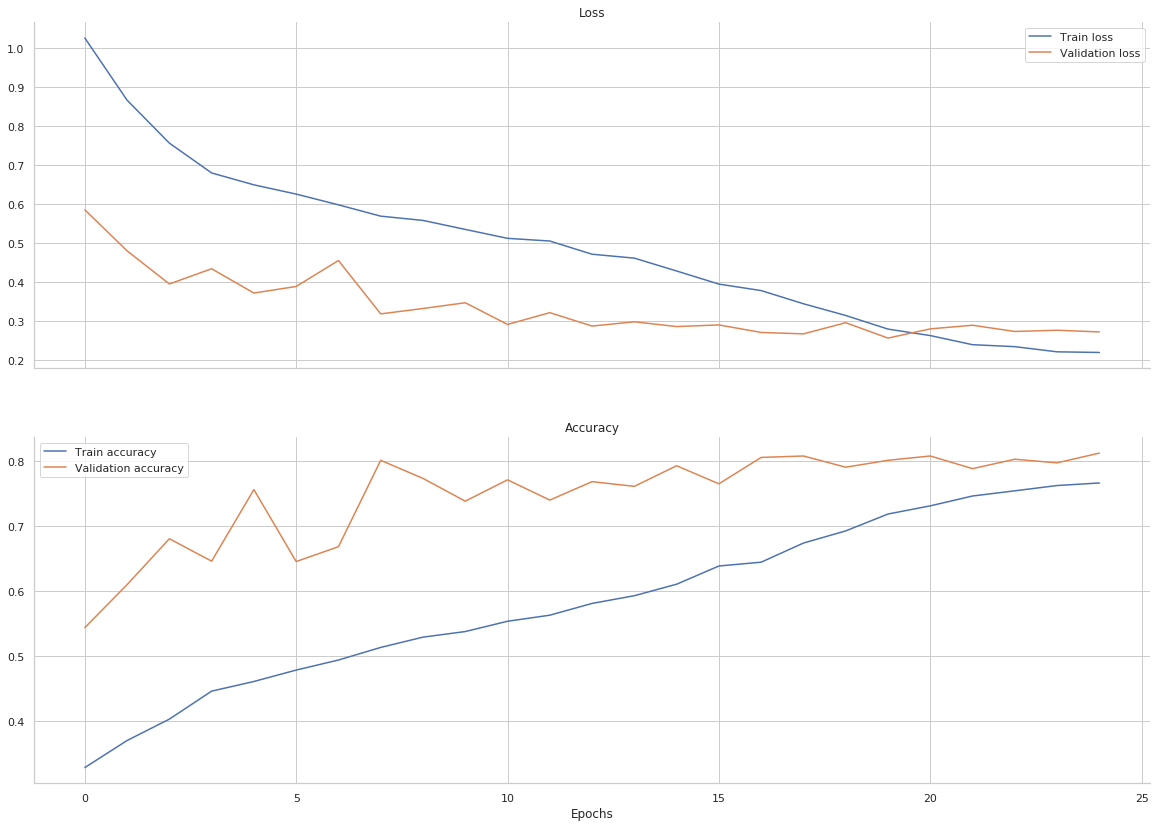

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

In [15]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

## Confusion Matrix

### Original thresholds

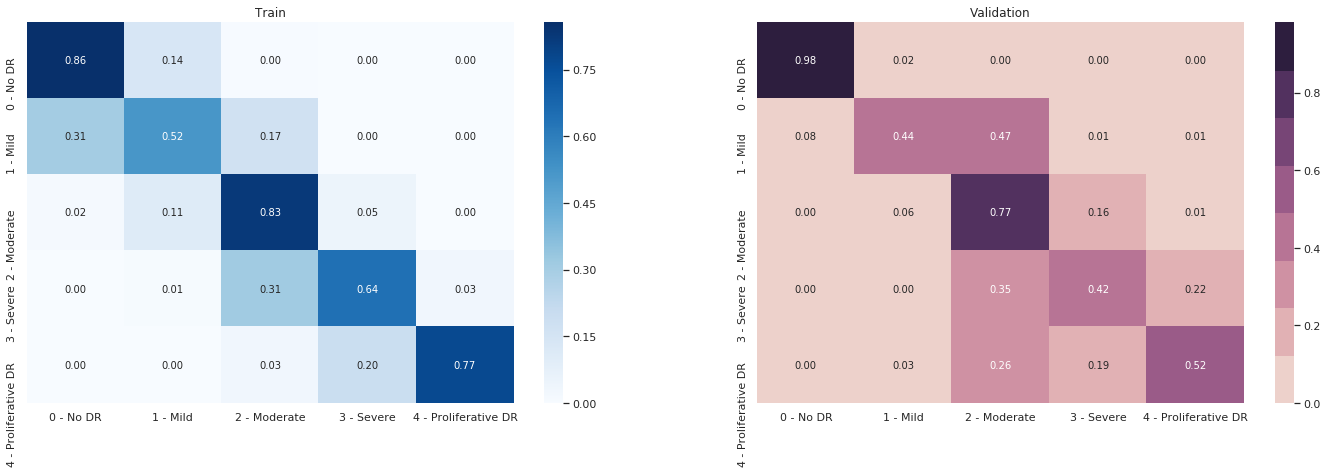

In [16]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

## Quadratic Weighted Kappa

In [17]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))
    
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

Train        Cohen Kappa score: 0.907
Validation   Cohen Kappa score: 0.906
Complete set Cohen Kappa score: 0.907


## Apply model to test set and output predictions

In [18]:
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

preds = apply_tta(model, test_generator, TTA_STEPS)
predictions = [classify(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

In [19]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

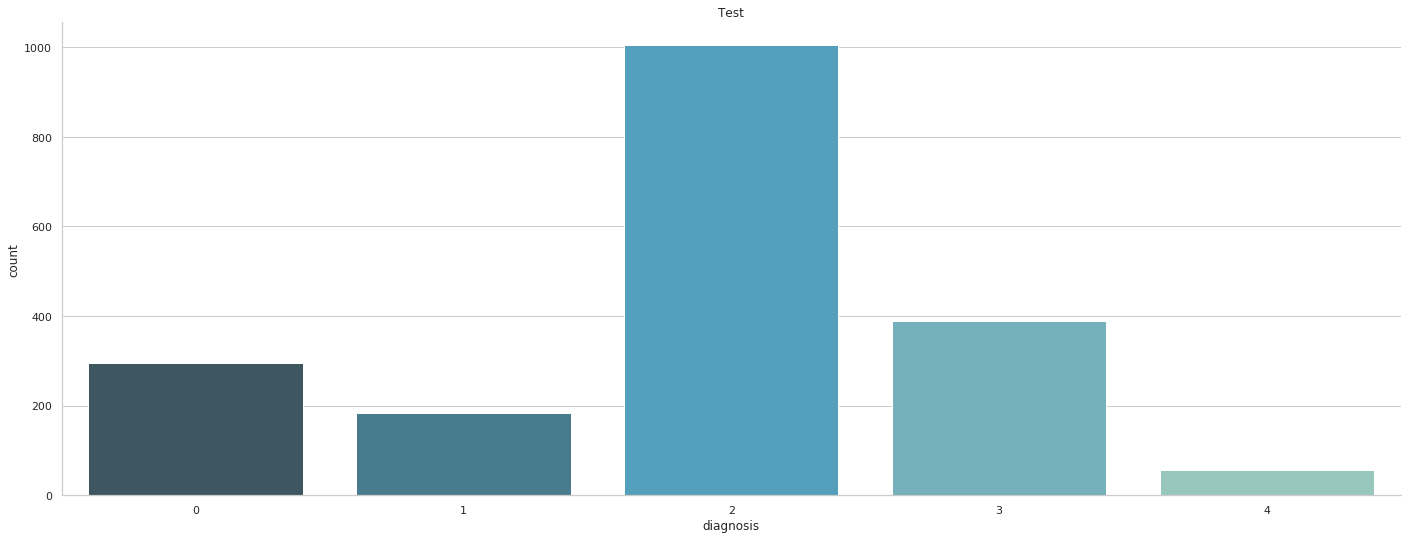

In [20]:
fig = plt.subplots(sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d").set_title('Test')
sns.despine()
plt.show()

In [21]:
results.to_csv('submission.csv', index=False)
display(results.head())

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3


## Save model

In [22]:
model.save_weights('../working/effNetB5_img224.h5')